# Introduction

In this notebook, we will explore the use of matrix representations of graphs, and show how their are direct matrix parallels for some of the algorithms that we have investigated.

In [1]:
import networkx as nx
from networkx import bipartite
import matplotlib.pyplot as plt
import nxviz as nv
from custom.load_data import load_university_social_network, load_amazon_reviews
from matplotlib import animation
from IPython.display import HTML
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

For this notebook, we will specifically see the connection between matrix operations and pathfinding between nodes.

# Toy Example: Linear Chain

To start, let us use a simple four-node network, in which nodes are joined in a chain. Convince yourself that this is is a linear chain by running the cell below.

In [2]:
nodes = list(range(4))
G1 = nx.Graph()

G1.add_nodes_from(nodes)
G1.add_edges_from(zip(nodes, nodes[1:]))

## Graph Form

When visualized as circles and lines, the graph looks like this:

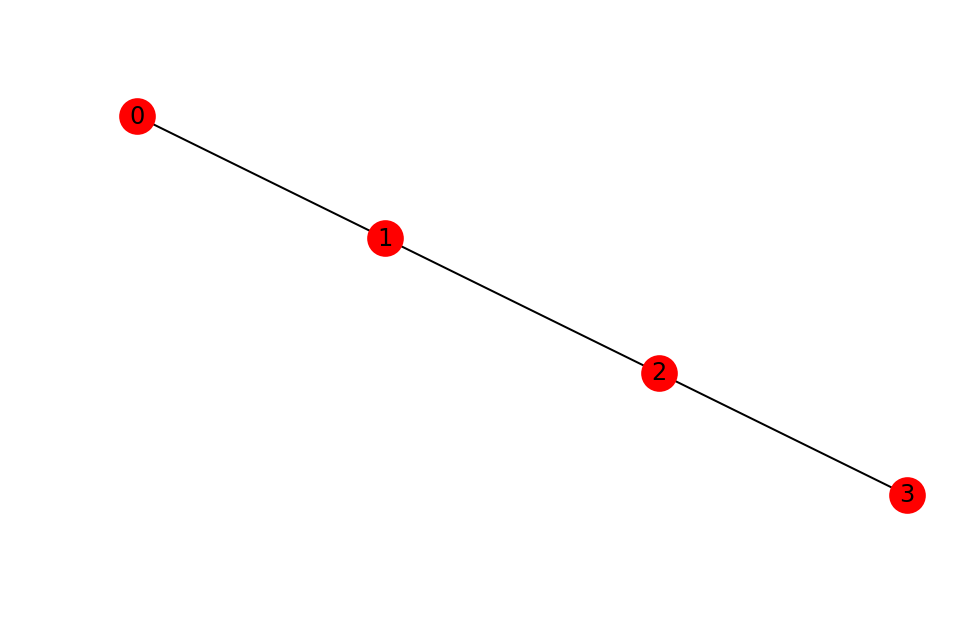

In [3]:
nx.draw(G1, with_labels=True)

## Matrix Form

When represented in matrix form, it looks like the plot below. (Explain row by columns = node by nodes.)

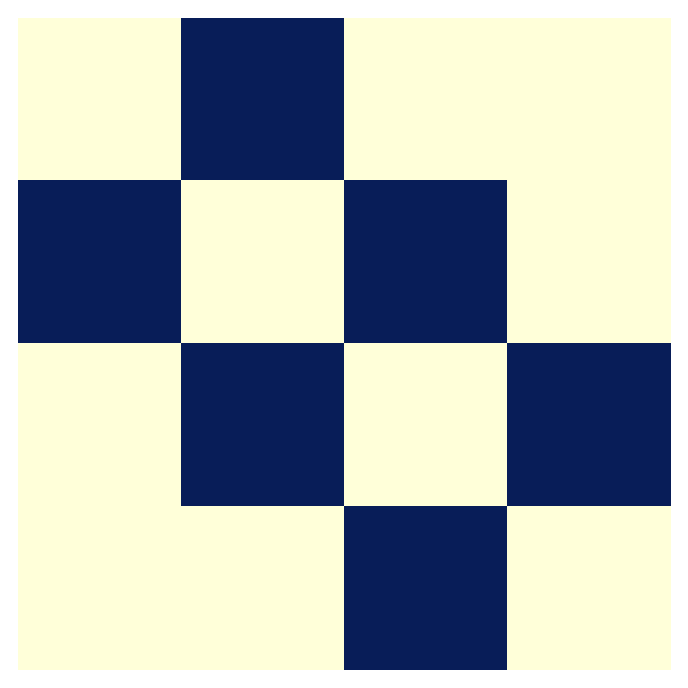

In [4]:
nv.MatrixPlot(G1).draw()

## Playing with the matrix form

NetworkX provides a `to_numpy_array()` function that will return a numpy array of the graph. That is used behind-the-scenes in `nxviz` to generate the MatrixPlot.

In [5]:
A1 = nx.to_numpy_array(G1, nodelist=sorted(G1.nodes()))
A1

array([[0., 1., 0., 0.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.]])

One neat result is that if we take the adjacency matrix, and matrix-matrix multiply it against itself ("matrix power 2"), we will get back a new matrix that has interesting properties.

In [6]:
import numpy as np

# One way of coding this up
np.linalg.matrix_power(A1, 2)

# Another equivalent way, that takes advantage of Python 3.5's matrix multiply operator
A1 @ A1

array([[1., 0., 1., 0.],
       [0., 2., 0., 1.],
       [1., 0., 2., 0.],
       [0., 1., 0., 1.]])

**Firstly**, if we look at the off-diagonals of the new matrix, this corresponds to the number of paths of length 2 that exist between those two nodes.

In [7]:
np.diag(A1 @ A1)

array([1., 2., 2., 1.])

Here, one path of length 2 exists between node 0 and node 2, and one path of length 2 exists between node 1 and node 3.

**Secondly**, you may notice that the diagonals look like the degree of the nodes. This is a unique property of the 2nd adjacency matrix power: for every node, there are $ d $ degree paths of length two to get back to that same node.

Not convinced? To get from a node and back, that's a path length of 2! :-)

Let's see if the following statment is true: The $ k^{th} $ matrix power of the graph adjacency matrix indicates how many paths of length $ k $ exist between each pair of nodes.

In [8]:
np.linalg.matrix_power(A1, 3)

array([[0., 2., 0., 1.],
       [2., 0., 3., 0.],
       [0., 3., 0., 2.],
       [1., 0., 2., 0.]])

Indeed, if we think about it, there is, by definition, no way sequence of graph traversals that will allow us to go back to a node within 3 steps. We will always end up at some neighboring node.

In addition, to get to the neighboring node in 3 steps, there are two ways to go about it:

- node -> neighbor -> node -> neighbor
- node -> neighbor -> neighbor's neighbor -> neighbor

Or for the case of this chain graph:

- 0 -> 1 -> 0 -> 1
- 0 -> 1 -> 2 -> 1

# Toy Example: Directed Linear Chain

Let's see if the same properties hold for a directed graph.

In [9]:
nodes

[0, 1, 2, 3]

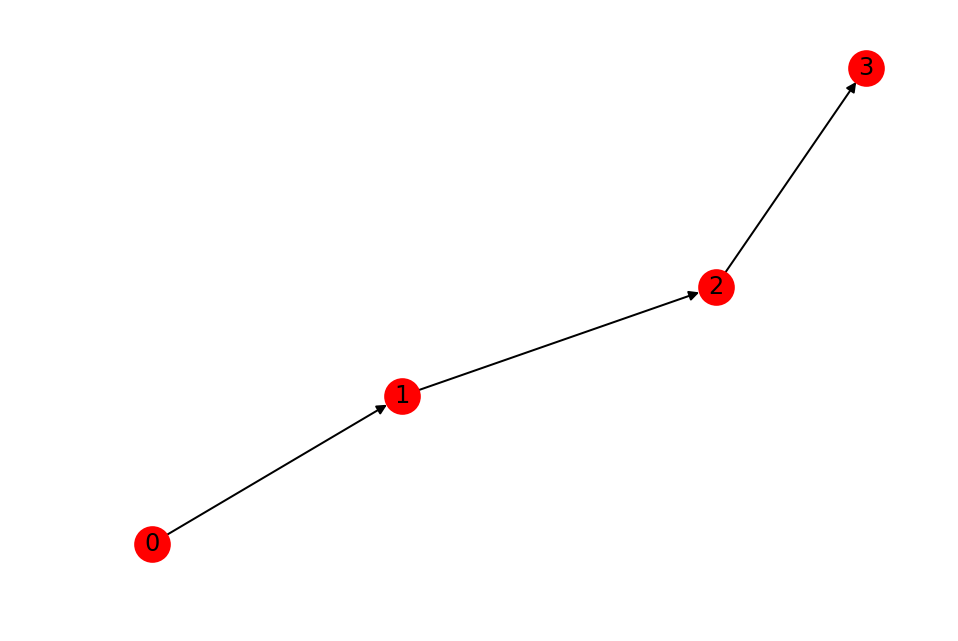

In [10]:
G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
G2.add_edges_from(zip(nodes, nodes[1:]))
nx.draw(G2, with_labels=True)

Recall that in a directed graph, the matrix representation is not guaranteed to be symmetric.

In [11]:
A2 = nx.to_numpy_array(G2)
A2

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

Let's look at the 2nd matrix power: the number of paths of length 2 between any pair of nodes.

In [12]:
np.linalg.matrix_power(A2, 2)

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

We see that there's only one path from node 0 to node 2 of length 2, and one path from node 1 to node 3. If you're not convinced of this, trace it for yourself!

## Exercise

In this directed graph, how many paths are there from node 0 to node 3 of length 3? Compute the 3rd matrix power and verify your answer.

In [13]:
np.linalg.matrix_power(A2, 3)

array([[0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# Real Data

Now that we've looked at a toy example, let's play around with a real dataset!

This dataset is a residence hall rating dataset. From the [source website](http://konect.uni-koblenz.de/networks/moreno_oz):

> This directed network contains friendship ratings between 217 residents living at a residence hall located on the Australian National University campus. A node represents a person and edges contain ratings of one friend to another.

For the purposes of this exercise, we will treat the edges as if they were unweighted.


In [14]:
G = load_university_social_network()

## Exercise

Use nxviz's MatrixPlot to draw the graph.

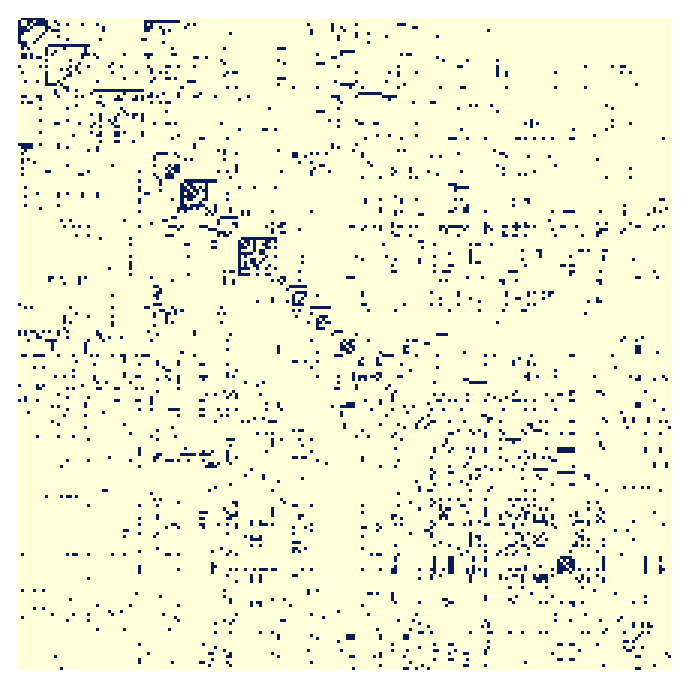

In [15]:
nv.MatrixPlot(G).draw()

## Exercise

Using what you know from the previous material, find out how many connected component subgraphs there are in the subgraph.

**Hint:** You may need to convert the graph to an undirected one first.

In [16]:
list(nx.connected_component_subgraphs(G.to_undirected()))

## Exercise

Since there is only one connected component subgraph, pick two nodes in the graph and see how many shortest paths there exist between those two nodes.

**Hint:** You will first need to know what the shortest path length is between those two nodes.

In [17]:
nx.shortest_path(G, 30, 100)

[30, 196, 115, 100]

In [18]:
A = nx.to_numpy_array(G)
np.linalg.matrix_power(A, 4)[29, 99]

40.0

# Message Passing

Message passing on graphs is a fascinating topic to explore. It's a neat way to think about a wide variety of problems, including the spread of infectious disease agents, rumours, and more. As it turns out, there's a direct matrix interpretation of the message passing operation.

To illustrate this more clearly, let's go back to the directed chain graph, `G2`.

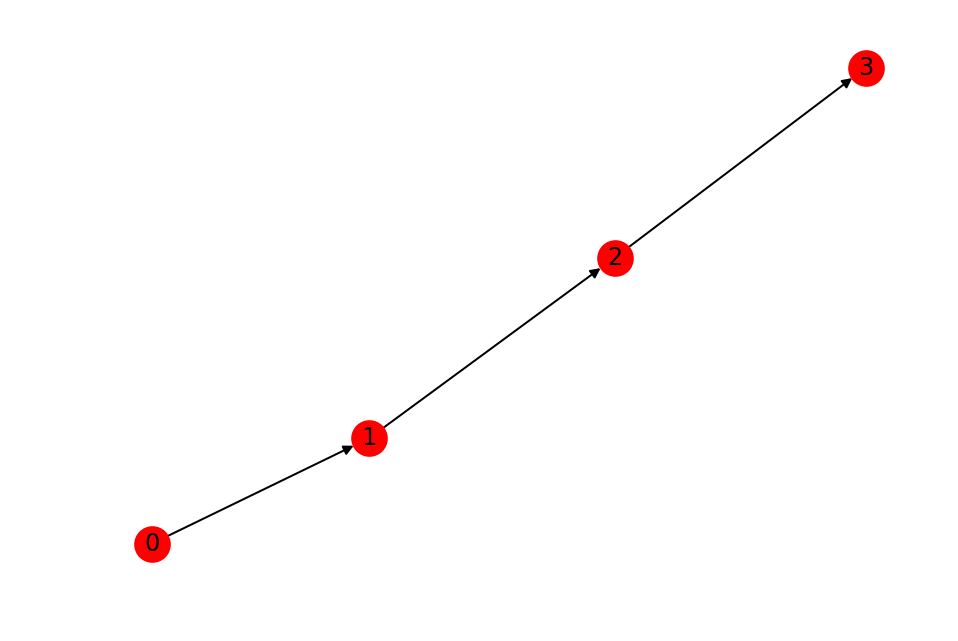

In [19]:
nx.draw(G2, with_labels=True)

If we have a message that begins at node 0, and it is only passed to its neighbors, then node 1 is the next one that possess the message. Node 1 then passes it to node 2, and so on, until it reaches node 3.

There are two key ideas to introduce here. Firstly, there is the notion of the **"wavefront"** of message passing: at the first time step, node 0 is the wavefront, and as time progresses, node 1, 2 and 3 progressively become the wavefront.

Secondly, as the message gets passed, the number of nodes that have seen the message progressively increases. 

Let's see how this gets implemented in matrix form.

## Matrix Message Passing

To represent the data, we start with a vertical array of messages of shape `(1, 4)`. Let's use the following conventions:

- `1` indicates that a node currently has the message.
- `0` indicates that a node currently does not have the message.

Since the message starts at node 0, let's put a `1` in that cell of the array, and `0`s elsewhere.

In [20]:
msg = np.array([1, 0, 0, 0]).reshape(1, 4)
msg

array([[1, 0, 0, 0]])

In order to simulate one round of message passing, we matrix multiply the message with the adjacency matrix.

In [21]:
msg2 = msg @ A2
msg2

array([[0., 1., 0., 0.]])

The interpretation now is that the message is currently at node 1.

To simulate a second round, we take that result and matrix multiply it against the adjacency matrix again.

In [22]:
msg3 = msg2 @ A2
msg3

array([[0., 0., 1., 0.]])

The interpretation now is that the message is currently at node 2.

### Exercise

Let's make an animation of this. I have pre-written the animation functions for you; your task is to implement the message passing function `propagate()` to precompute at each time step the message status.

In [23]:
# fig, ax = plt.subplots()

def propagate(G, msg, n_frames):
    """
    Computes the node values based on propagation.
    
    Intended to be used before or when being passed into the 
    anim() function (defined below).
    
    :param G: A NetworkX Graph.
    :param msg: The initial state of the message.
    :returns: A list of 1/0 representing message status at 
        each node.
    """
    # Initialize a list to store message states at each timestep.
    msg_states = []
    
    # Set a variable `new_msg` to be the initial message state.
    new_msg = msg
    
    # Get the adjacency matrix of the graph G.
    A = nx.to_numpy_array(G)
    
    # Perform message passing at each time step
    for i in range(n_frames):
        msg_states.append(new_msg)
        new_msg = new_msg @ A
        
    # Return the message states.
    return msg_states

The rest of the `matplotlib` animation functions are shown below.

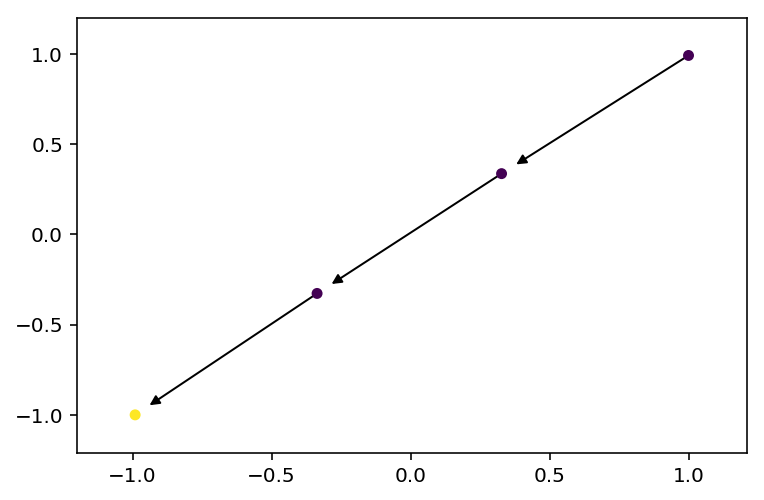

In [24]:
def update_func(step, nodes, colors):
    """
    The update function for each animation time step.
    
    :param step: Passed in from matplotlib's FuncAnimation. Must
        be present in the function signature.
    :param nodes: Returned from nx.draw_networkx_edges(). Is an
        array of colors.
    :param colors: A list of pre-computed colors.
    """
    nodes.set_array(colors[step].ravel())
    return nodes

def anim(G, initial_state, n_frames=4):
    colors = propagate(G, initial_state, n_frames)
    fig = plt.figure()
    pos = {i:(i, i) for i in range(len(G))}
    adj = nx.to_numpy_array(G)
    pos = nx.kamada_kawai_layout(G)
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors[0].ravel(), node_size=20)
    ax = nx.draw_networkx_edges(G, pos)
    return animation.FuncAnimation(fig, update_func, frames=range(n_frames), fargs=(nodes, colors))


# Initialize the message
msg = np.zeros(len(G2))
msg[0] = 1

# Animate the graph with message propagation.
HTML(anim(G2, msg, n_frames=4).to_html5_video())

### Exercise

Visualize how a rumour would spread in the university dorm network. You can initialize the message on any node of your choice.

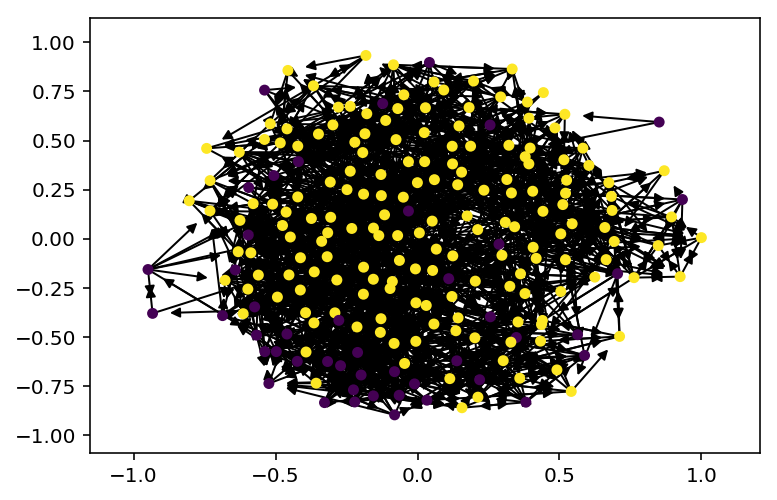

In [25]:
msg = np.zeros(len(G))
msg[0] = 1
HTML(anim(G, msg, n_frames=4).to_html5_video())

# Bipartite Graph Matrices

The section on message passing above assumed unipartite graphs, or at least graphs for which messages can be meaningfully passed between nodes. 

In this section, we will look at bipartite graphs. 

Recall from before the definition of a bipartite graph:

- Nodes are separated into two partitions (hence 'bi'-'partite').
- Edges can only occur between nodes of different partitions.

Bipartite graphs have a natural matrix representation, known as the **biadjacency matrix**. Nodes on one partition are the rows, and nodes on the other partition are the columns.

NetworkX's `bipartite` module provides a function for computing the biadjacency matrix of a bipartite graph.

Let's start by looking at a toy bipartite graph, a "customer-product" purchase record graph, with 4 products and 3 customers. The matrix representation might be as follows:

In [26]:
import numpy as np
# Rows = customers, columns = products, 1 = customer purchased product, 0 = customer did not purchase product.
cp_mat = np.array([[0, 1, 0, 0],
                   [1, 0, 1, 0],
                   [1, 1, 1, 1]])


From this "bi-adjacency" matrix, one can compute the projection onto the customers, matrix multiplying the matrix with its transpose.

In [27]:
c_mat = cp_mat @ cp_mat.T  # c_mat means "customer matrix"
c_mat

array([[1, 0, 1],
       [0, 2, 2],
       [1, 2, 4]])

**Pause here and read carefully!**

What we get is the connectivity matrix of the customers, based on shared purchases. The diagonals are the degree of the customers in the original graph, i.e. the number of purchases they originally made, and the off-diagonals are the connectivity matrix, based on shared products.

To get the products matrix, we make the transposed matrix the left side of the matrix multiplication.

In [28]:
p_mat = cp_mat.T @ cp_mat  # p_mat means "product matrix"
p_mat

array([[2, 1, 2, 1],
       [1, 2, 1, 1],
       [2, 1, 2, 1],
       [1, 1, 1, 1]])

You may now try to convince yourself that the diagonals are the number of times a customer purchased that product, and the off-diagonals are the connectivity matrix of the products, weighted by how similar two customers are.

## Exercises 

In the following exercises, you will now play with a customer-product graph from Amazon. This dataset was downloaded from [UCSD's Julian McAuley's website](http://jmcauley.ucsd.edu/data/amazon/), and corresponds to the digital music dataset.

This is a bipartite graph. The two partitions are:

- `customers`: The customers that were doing the reviews.
- `products`: The music that was being reviewed.

In the original dataset (see the original JSON in the `datasets/` directory), they are referred to as:

- `customers`: `reviewerID`
- `products`: `asin`

In [29]:
G_amzn = load_amazon_reviews()

100%|██████████| 64706/64706 [00:00<00:00, 216273.67it/s]


NetworkX provides [`nx.bipartite.matrix.biadjacency_matrix()`](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.matrix.biadjacency_matrix.html#networkx.algorithms.bipartite.matrix.biadjacency_matrix) function that lets you get the biadjacency matrix of a graph object. This returns a `scipy.sparse` matrix. Sparse matrices are commonly used to represent graphs, especially large ones, as they take up much less memory.

### Exercise

Read the [docs](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.matrix.biadjacency_matrix.html#networkx.algorithms.bipartite.matrix.biadjacency_matrix) on how to use the `biadjacency_matrix()` function. 

You probably would want to first define a function that gets all nodes from a partition.

In [30]:
def get_partition_nodes(G, partition):
    """
    A function that returns nodes from one partition.
    
    Assumes that the attribute key that stores the partition information
    is 'bipartite'.
    """
    return [n for n, d in G.nodes(data=True) if d['bipartite'] == partition]

### Exercise

Now, use the `get_partition_nodes()` function to get the `row_order` and `column_order` nodes from the Amazon music review graph, then get the biadjacency matrix.

In [31]:
customer_nodes = get_partition_nodes(G_amzn, 'customer')
mat = nx.bipartite.biadjacency_matrix(G_amzn, customer_nodes)

### Exercise

Let's find out which customers reviewed the most number of music items.

To do so, you can break the problem into a few steps.

First off, compute the customer projection using matrix operations.

In [32]:
customer_mat = mat @ mat.T

Next, get the diagonals of the customer-customer matrix. Recall here that in `customer_mat`, the diagonals correspond to the degree of the customer nodes in the bipartite matrix.

**Hint:** SciPy sparse matrices provide a `.diagonal()` method that returns the diagonal elements.

In [33]:
# Get the diagonal.
degrees = customer_mat.diagonal()

Finally, find the index of the customer that has the highest degree.

In [34]:
cust_idx = np.argmax(degrees)
cust_idx

294

It should be customer 294 in the `customer_nodes` list.

### Exercise

Verify that this holds when looking at the degrees of each customer in `customer_nodes`.

In [35]:
cust_degrees = [G_amzn.degree(n) for n in customer_nodes]
np.argmax(cust_degrees)

294

### Exercise

Let's now also compute which two customers are similar, based on shared reviews. To do so involves the following steps:

1. We construct a sparse matrix consisting of only the diagonals. `scipy.sparse.diags(elements)` will construct a sparse diagonal matrix based on the elements inside `elements`.
1. Subtract the diagonals from the customer matrix projection. This yields the customer-customer similarity matrix, which should only consist of the off-diagonal elements of the customer matrix projection.
1. Finally, get the indices where the weight (shared number of between the customers is highest. (*This code is provided for you.*)

In [36]:
import scipy.sparse as sp

In [37]:
# Construct diagonal elements.
customer_diags = sp.diags(degrees)
# Subtract off-diagonals.
off_diagonals = customer_mat - customer_diags
# Compute index of most similar individuals.
np.unravel_index(np.argmax(off_diagonals), customer_mat.shape)

(294, 86)

# Performance: Object vs. Matrices

Finally, to motivate why you might want to use matrices rather than graph objects to compute some of these statistics, let's time the two ways of getting to the same answer.

## Objects

In [41]:
from time import time

start = time()

# Compute the projection
G_cust = nx.bipartite.weighted_projected_graph(G_amzn, customer_nodes)

# Identify the most similar customers
most_similar_customers = sorted(G_cust.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[0]

end = time()
print(f'{end - start:.3f} seconds')
print(f'Most similar customers: {most_similar_customers}')

23.205 seconds
Most similar customers: ('A3HU0B9XUEVHIM', 'A9Q28YTLYREO7', {'weight': 154})


## Matrices

In [42]:
start = time()

# Compute the projection using matrices
mat = nx.bipartite.matrix.biadjacency_matrix(G_amzn, customer_nodes)
cust_mat = mat @ mat.T

# Identify the most similar customers
degrees = customer_mat.diagonal()
customer_diags = sp.diags(degrees)
off_diagonals = customer_mat - customer_diags
c1, c2 = np.unravel_index(np.argmax(off_diagonals), customer_mat.shape)

end = time()
print(f'{end - start:.3f} seconds')
print(f'Most similar customers: {customer_nodes[c1]}, {customer_nodes[c2]}, {cust_mat[c1, c2]}')

0.695 seconds
Most similar customers: A9Q28YTLYREO7, A3HU0B9XUEVHIM, 154


You may notice that it's much easier to read the "objects" code, but the matrix code way outperforms the object code. This then becomes a great reason to use matrices (even better, sparse matrices)!